# Import Packages for Analysis & Model Building & Clean up initial dataset


In [120]:
#Standard imports
import pandas as pd
import numpy as np 

#Visualizations
import seaborn as sns
import geopandas as gpd
import plotly
from shapely.geometry import Point, Polygon
import plotly.figure_factory as ff
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import (ColumnDataSource, GMapOptions, LinearColorMapper,FactorRange, ColorBar, BasicTicker, PrintfTickFormatter)
from bokeh.palettes import Spectral3, Spectral6, Spectral7
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.plotting import gmap
from bokeh.layouts import gridplot, row
import matplotlib.pyplot as plt
%matplotlib inline

output_notebook()

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
COLORS = ['#999594', '#D54E4F', '#FC7D59']

Loading BokehJS ...

# Initial Data preparation

Here we clean up the data to run some EDA to get a sense for what we might featurize

In [3]:
#Load the three datasets I was provided
df_labels = pd.read_csv("training_set_labels.csv")
df_train_set = pd.read_csv("training_set_values.csv")
df_test = pd.read_csv('test_set_values.csv')

#Merge Labels / Value dataset into our core dataframe
df = pd.merge(df_labels,df_train_set,how="inner",on="id")

In [5]:
#Get a sense of our classification split
#Key takeout -> Not a lot of functional needs repair (7%)
df.groupby(['status_group']).count()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
status_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
functional,32259,32259,32259,30278,32259,30259,32259,32259,32259,32259,32259,32054,32259,32259,32259,32259,32259,32259,30581,32259,30386,17771,30586,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259
functional needs repair,4317,4317,4317,3880,4317,3877,4317,4317,4317,4317,4317,4316,4317,4317,4317,4317,4317,4317,4161,4317,4094,2313,4017,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317
non functional,22824,22824,22824,21607,22824,21609,22824,22824,22824,22824,22824,22659,22824,22824,22824,22824,22824,22824,21324,22824,21043,11150,21741,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824


In [6]:
#functional needs repair make up only 7% of results. For ease of EDA we will combine them into non-functional
def convert_well_status_group(df):
    status_group_num = {'non functional': 0, 'functional': 1, 'functional needs repair':0}
    df['functional_flag'] = df['status_group'].map(status_group_num)

In [7]:
#get rid of null values
def clear_null_values(df):
    df['funder_clean'] = df['funder'].fillna('unknown')
    df['installer_clean'] = df['installer'].fillna('unknown')
    df['subvillage_clean'] = df['subvillage'].fillna('none')
    df['public_meeting_clean'] = df['public_meeting'].fillna('none')
    df['scheme_management_clean'] = df['scheme_management'].fillna('none')
    df['scheme_name_clean'] = df['scheme_name'].fillna('none')
    df['permit_clean'] = df['permit'].fillna('unknown')
    df['construction_year_clean'] = df['construction_year'].fillna(0)
    df['installer'].replace(to_replace = '0', value ='unknown' , inplace=True) # filling 0 values with unknown

In [15]:
#crosstab variables to see what we can drop - I did a lot of manual testing with the below code
pd.crosstab(df['district_code'],df['region_code'])

region_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,40,60,80,90,99
district_code,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,888,189,595,698,1128,984,93,0,0,423,728,298,544,574,679,874,1251,772,341,171,550,0,0,0,0,0,423
2,0,1206,519,408,521,301,497,0,0,652,530,500,995,339,521,1159,802,494,739,716,274,0,0,0,0,0,0
3,361,109,877,323,997,108,215,300,0,750,653,871,377,337,428,727,1401,402,69,396,297,0,0,0,0,0,0
4,347,0,1225,110,627,190,0,0,266,121,2476,1106,177,402,180,56,0,403,599,438,276,0,0,0,0,0,0
5,358,201,620,293,96,0,0,0,124,694,564,204,0,170,0,0,514,0,332,0,186,0,0,0,0,0,0
6,224,310,109,266,671,26,0,0,0,0,0,1034,0,157,0,0,453,88,488,248,0,0,0,0,0,0,0
7,0,1009,434,127,0,0,0,0,0,0,349,626,0,0,0,0,191,260,347,0,0,0,0,0,0,0,0
8,0,0,0,288,0,0,0,0,0,0,0,0,0,0,0,0,387,236,132,0,0,0,0,0,0,0,0


Key takeout -> crosstabs show a bunch of redundant fields:

-lots of construction_year without a date, we should average a number from other variables to fill 

-recorded_by is just a single geo consultant -> drop recorded_by 

-extraction type is almost the same as extraction_type_group so we should drop one -> drop extraction_type_class 

-management group can be dropped as it's covered by management -> drop management_group 

-payment type can be dropped as it's covered by payment -> drop payment_type 

-quality_group can be dropped as it's covered by water_quality -> drop quality_group 

-quantity & quantity_group the same so we should drop quantity_group -> drop quantity_group 

-source type can be dropped as it's covered by source. Source Class can effectively be dropped too -> drop source_type and drop source_class 

-waterpoint_type & waterpoint_type_group the same so drop waterpoint_type_group -> drop waterpoint_type_group

In [39]:
#drop unneccessary fields
def drop_features(df):
    df.drop(['recorded_by','extraction_type_class','management_group','payment_type','quality_group','quantity_group','source_type','source_class','waterpoint_type_group'], axis=1, inplace=True)

In [ ]:
#Run our transformations to give us a dataset to investigate.
convert_well_status_group(df)
clear_null_values(df)
drop_features(df)

In [26]:
# Explore the number of unique values for each variable to understand Cardinality
#Key Takeout -> Several features have extremely high cardinality. This will make encoding hard. Consider CatBoost
for col in df.columns:
    print('{}: {} unique values'.format(col, df[col].nunique()))

id: 59400 unique values
status_group: 3 unique values
amount_tsh: 98 unique values
date_recorded: 356 unique values
funder: 1897 unique values
gps_height: 2428 unique values
installer: 2144 unique values
longitude: 57516 unique values
latitude: 57517 unique values
wpt_name: 37400 unique values
num_private: 65 unique values
basin: 9 unique values
subvillage: 19287 unique values
region: 21 unique values
region_code: 27 unique values
district_code: 20 unique values
lga: 125 unique values
ward: 2092 unique values
population: 1049 unique values
public_meeting: 2 unique values
scheme_management: 12 unique values
scheme_name: 2696 unique values
permit: 2 unique values
construction_year: 55 unique values
extraction_type: 18 unique values
extraction_type_group: 13 unique values
management: 12 unique values
payment: 7 unique values
water_quality: 8 unique values
quantity: 5 unique values
source: 10 unique values
waterpoint_type: 7 unique values
functional_flag: 2 unique values
funder_clean: 1898

# Continuous Features Investigation

In [40]:
#Review fields
#Key takeout -> A quick Google shows avg altitude / lat / long are quite off from the means here.
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,functional_flag,construction_year_clean
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.543081,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.498145,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000,2013.000000


In [214]:
#Explore our continuous features with a correlation matrix
#Key takeout -> Low correlation between Lat/Long and Region makes little sense and must be investigated.
df.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,functional_flag,construction_year_clean
id,1.000000,-0.005321,-0.004692,0.001930,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,-0.003983,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.012364,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,0.052427,0.067915
gps_height,-0.004692,0.076650,1.000000,-0.021465,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,0.112990,0.658727
longitude,0.001930,0.012364,-0.021465,1.000000,-0.298460,0.044887,0.147450,0.252093,0.062275,0.457680,0.017413,0.457680
latitude,0.001718,-0.052670,-0.035751,-0.298460,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,0.000411,-0.245278
num_private,-0.002629,0.002944,0.007237,0.044887,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,0.005780,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.147450,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,-0.104178,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.252093,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,-0.056028,0.048315
population,-0.002813,0.016288,0.135003,0.062275,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,0.017674,0.260910
construction_year,-0.002082,0.067915,0.658727,0.457680,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,0.051457,1.000000


In [215]:
# Look at the distribution of each continuous variabel to understand if we should featurize
# Key Takeouts -> The construction_year mean suggests we have a LOT of zero values.

def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby('functional_flag')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    functional = df[df['functional_flag']==1][feature]
    non_functional = df[df['functional_flag']==0][feature]
    tstat, pval = stats.ttest_ind(functional, non_functional, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, pval))
    
for feature in ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private','region_code','district_code','population','construction_year_clean']:
    describe_cont_feature(feature)


*** Results for amount_tsh ***
                   count        mean          std  min  25%  50%   75%  \
functional_flag                                                          
0                27141.0  146.320460  1276.092381  0.0  0.0  0.0   0.0   
1                32259.0  461.798235  3889.735284  0.0  0.0  0.0  50.0   

                      max  
functional_flag            
0                117000.0  
1                350000.0  
t-statistic: 13.7, p-value: 1.01e-42
None

*** Results for gps_height ***
                   count        mean         std   min  25%    50%     75%  \
functional_flag                                                              
0                27141.0  582.917505  643.934987 -59.0  0.0  302.0  1217.0   
1                32259.0  740.131188  724.193683 -90.0  0.0  550.0  1404.0   

                    max  
functional_flag          
0                2770.0  
1                2628.0  
t-statistic: 28.0, p-value: 2.41e-171
None

*** Results for longitud

In [216]:
#create a table of continuous variables to explore
df_continuous = df[['functional_flag','amount_tsh','gps_height','longitude','latitude','num_private','region_code','district_code','population','construction_year_clean']].copy()
df_continuous.head()

,functional_flag,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year_clean
0,1,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,1,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,1,25.0,686,37.460664,-3.821329,0,21,4,250,2009
3,0,0.0,263,38.486161,-11.155298,0,90,63,58,1986
4,1,0.0,0,31.130847,-1.825359,0,18,1,0,0


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



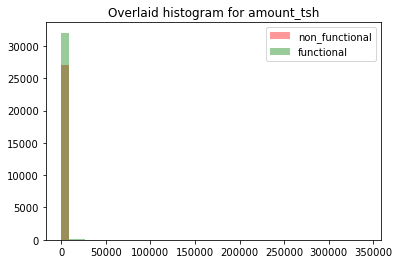

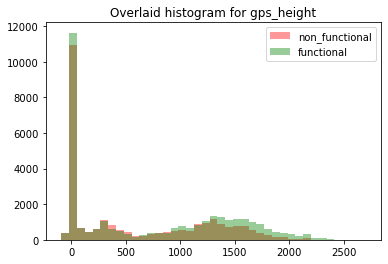

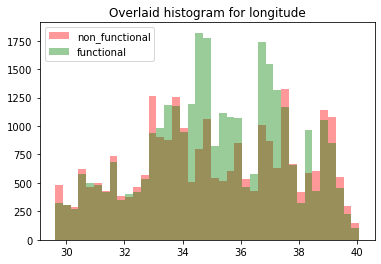

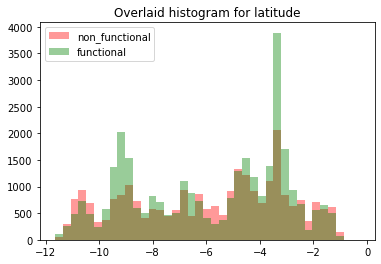

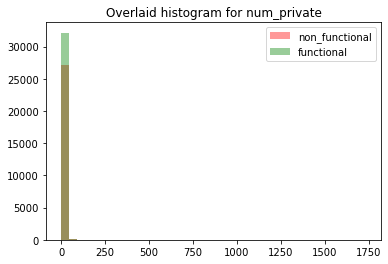

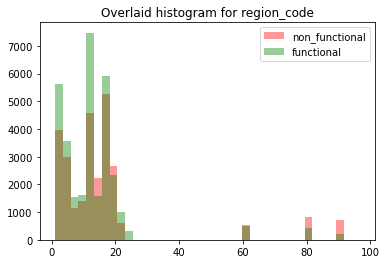

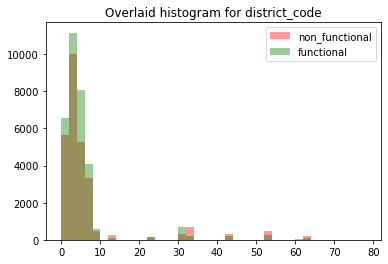

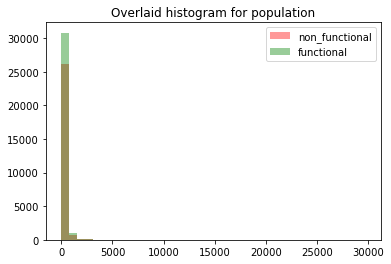

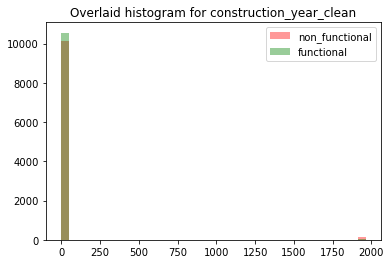

In [217]:
# Plot overlaid histograms for continuous features to understand them
# Key Takeouts -> We will need to transform GPS_Height, Lat, Long and Construction_year.
for i in ['amount_tsh','gps_height','longitude','latitude','num_private','region_code','district_code','population','construction_year_clean']:
    non_functional = list(df_continuous[df_continuous['functional_flag'] == 0][i].dropna())
    functional = list(df_continuous[df_continuous['functional_flag'] == 1][i].dropna())    
    xmin = min(min(non_functional), min(functional))
    xmax = max(max(non_functional), max(functional))
    width = (xmax - xmin) / 40
    sns.distplot(non_functional, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(functional, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['non_functional','functional'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

In [218]:
#Diving deeper into the relationship between functioning class and num_private
#Key takeout -> Most values are zero, probably not an important feature
pd.crosstab(df['functional_flag'],df['num_private'])

num_private,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,20,22,23,24,25,26,27,30,32,34,35,38,39,41,42,45,47,50,55,58,60,61,62,65,80,87,93,94,102,111,120,131,136,141,150,160,180,213,240,280,300,450,668,672,698,755,1402,1776
functional_flag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26845,33,9,15,11,15,26,11,15,1,0,6,1,2,8,2,7,10,1,0,0,6,0,1,1,1,7,0,3,22,3,1,10,9,5,1,0,0,2,1,11,14,1,7,0,6,0,2,0,0,0,5,1,0,1,0,0,1,0,0,0,0,0,0,1
1,31798,40,14,12,9,31,55,15,31,3,4,5,4,1,27,6,10,4,5,1,5,6,2,1,0,39,3,1,1,8,7,0,26,12,0,0,4,1,1,0,11,1,0,21,1,14,1,5,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,0


In [219]:
#Bin GPS_height data to investigate
heightbins = [-100,-0.000001,0.00001,300,700,900,1100,1300,1500,1750,3000]
heightlabels = ['below 0','zero','0<x<300','300<x<700','700<x<900','900<x<1100','1100<x<1300','1300<x<1500','1500<x<1750','1750<x<3000']

df['gps_height_clean']=pd.cut(df['gps_height'], bins=heightbins, labels=heightlabels, include_lowest=True)

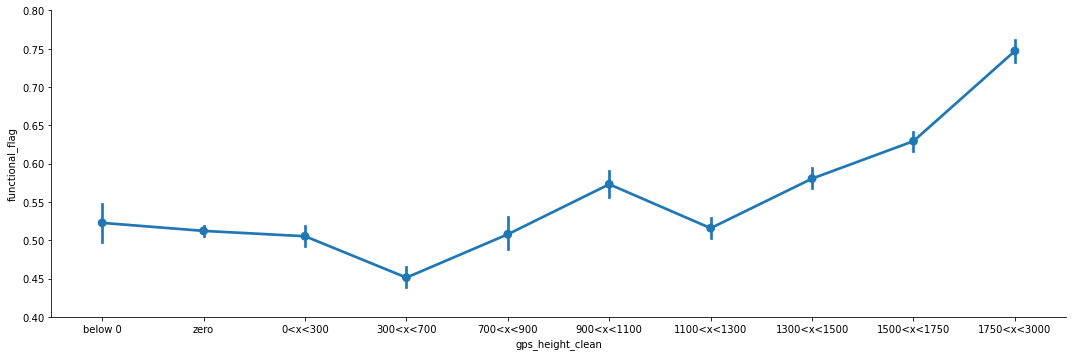

In [220]:
#Plot our GPS_Height Bins
#Key Takeout -> clearly the higher we are the higher the failure rate, I've adjusted my bins to create decently sized buckets at each altitude to reduce variance
for col in ['gps_height_clean']:
    sns.catplot(x=col, y='functional_flag', data=df, kind='point', aspect=3)
    plt.ylim(0.4,0.8)

In [221]:
plt.figure(figsize=(20, 20))


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

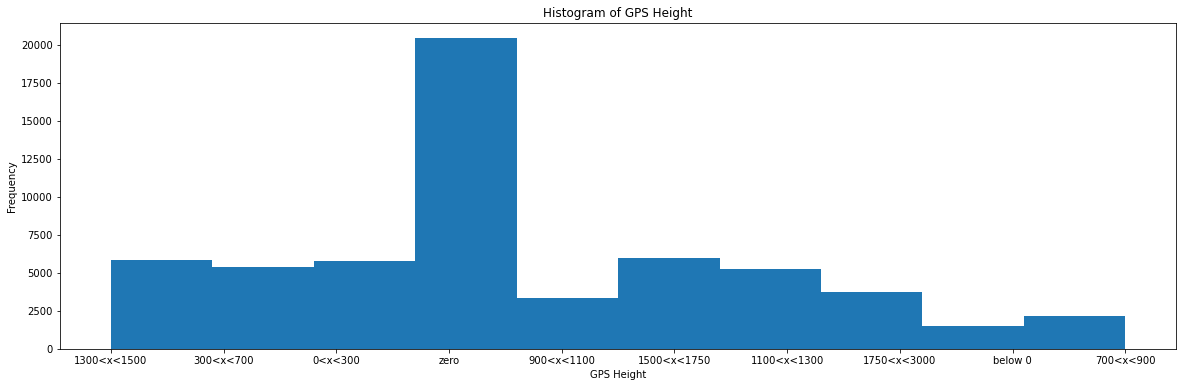

In [222]:
#Dive into GPS_Height distribution
#A quick Google shows the mean altitude of Tanzania is 1000m. Yet this histogram shows many 0 records. 
#Thus we must try and figure out the actual elevation of zero values while still understanding that many zero values actually are zero!

# Create a larger figure
plt.figure(figsize=(20, 6))

# Plot the histogram
plt.hist(df['gps_height_clean'])

# Add axis labels and a title
plt.xlabel('GPS Height')
plt.ylabel('Frequency')
plt.title('Histogram of GPS Height')

# Show the plot
plt.show()

In [223]:
#Bin construction_year data
constructionyearbins = [0,1959,1969,1979,1989,1999,2009,2022]
constructionyearlabels = ['no record','60s','70s','80s','90s','00s','10s to 2022']
df['construction_decade']=pd.cut(df['construction_year_clean'], bins=constructionyearbins, labels=constructionyearlabels, include_lowest=True)

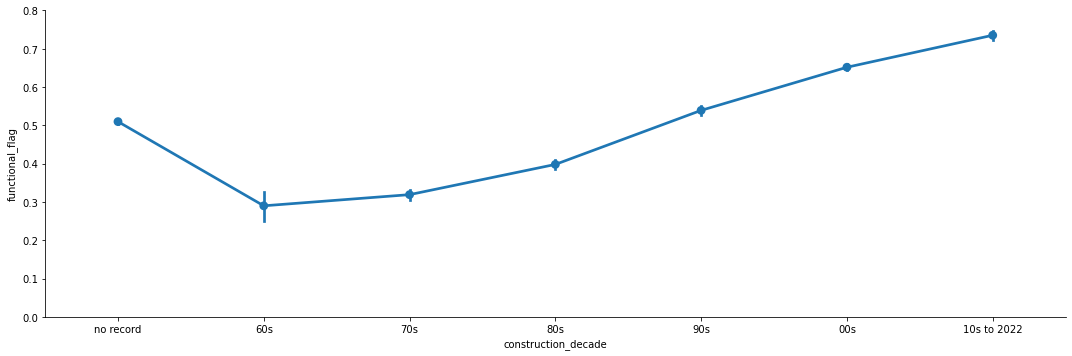

In [224]:
#Plot construction year vs failre
#Key Takeout -> clearly the higher we are the higher the failure rate, I've adjusted my bins to create decently sized buckets at each altitude to reduce variance
for col in ['construction_decade']:
    sns.catplot(x=col, y='functional_flag', data=df, kind='point', aspect=3)
    plt.ylim(0,0.8)

In [225]:
#Write a function to detect outlier Features
def detect_outlier(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))


# Conclusions for Continuous Variables

From the histograms it's pretty clear we have uneven distributions and will need to carry out some transformations:

amount_tsh: A look at the TTest suggest this should be a feature. We can either turn it into a flag or further look at the distribution of non-zero values.

gps_height: The high number of 0 values in a country with an average altitude of 1000m suggests missing data. Will fill with the mean of the region/district/lga or ward

latitude and longitude: Plenty of missing values. We will use a mean of the region, lga or Ward to fill in zero values as it appears to he a useful feature. We will also apply a function to center the distribution.

num_private: Given the relatively low correlation with well functioning, we may consider just turning this into a flag.

Region_Code: Clearly a decent indicator of whether a well functions. We need to arrive at some solid location and altitude feature.

District_code: Same as region_code.

Construction_year: It would make sense for this to be a key feature, yet many of the values remain empty. We could look to replace zero values with an average based on funder, installer, scheme_name, region and management. We will dive deeper into what correlations exist between these fields and date of construction as I imagine particular installers or schemes operated at particular times.

# Categorical Features Investigation

In [227]:
#Create a categorical dataframe to inspect
df_categorical = df[['id','date_recorded','wpt_name','basin','region','waterpoint_type','functional_flag','funder_clean','installer_clean','subvillage_clean','public_meeting_clean','scheme_management_clean','scheme_name_clean','permit_clean']].copy()

In [228]:
#Quickly look at the height of LGA's
#Key Takeout -> A quick search shows Bariandi is at 1250m, the issue is biharamulo is at 1250 but we see all data points binned at zero thus lga is too granular to apply an average for the dimension to zero quantities
pd.crosstab(df['gps_height_clean'],df['lga'])

lga,Arusha Rural,Arusha Urban,Babati,Bagamoyo,Bahi,Bariadi,Biharamulo,Bukoba Rural,Bukoba Urban,Bukombe,Bunda,Chamwino,Chato,Chunya,Dodoma Urban,Geita,Hai,Hanang,Handeni,Igunga,Ilala,Ileje,Ilemela,Iramba,Iringa Rural,Kahama,Karagwe,Karatu,Kasulu,Kibaha,Kibondo,Kigoma Rural,Kigoma Urban,Kilindi,Kilolo,Kilombero,Kilosa,Kilwa,Kinondoni,Kisarawe,Kishapu,Kiteto,Kondoa,Kongwa,Korogwe,Kwimba,Kyela,Lindi Rural,Lindi Urban,Liwale,Longido,Ludewa,Lushoto,Mafia,Magu,Makete,Manyoni,Masasi,Maswa,Mbarali,Mbeya Rural,Mbinga,Mbozi,Mbulu,Meatu,Meru,Misenyi,Missungwi,Mkinga,Mkuranga,Monduli,Morogoro Rural,Morogoro Urban,Moshi Rural,Moshi Urban,Mpanda,Mpwapwa,Mtwara Rural,Mtwara Urban,Mufindi,Muheza,Muleba,Musoma Rural,Mvomero,Mwanga,Nachingwea,Namtumbo,Nanyumbu,Newala,Ngara,Ngorongoro,Njombe,Nkasi,Nyamagana,Nzega,Pangani,Rombo,Rorya,Ruangwa,Rufiji,Rungwe,Same,Sengerema,Serengeti,Shinyanga Rural,Shinyanga Urban,Siha,Sikonge,Simanjiro,Singida Rural,Singida Urban,Songea Rural,Songea Urban,Sumbawanga Rural,Sumbawanga Urban,Tabora Urban,Tandahimba,Tanga,Tarime,Temeke,Tunduru,Ukerewe,Ulanga,Urambo,Uyui
gps_height_clean,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
below 0,0,0,0,319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,133,4,0,0,0,0,0,0,0,0,43,11,0,0,0,0,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108,0,0,0,0,0,0,0,139,109,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,0,0,0,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,168,0,0,0,0,0
zero,0,0,0,9,224,1013,403,487,88,514,0,347,236,298,358,488,0,0,0,338,2,231,116,0,0,836,771,0,0,2,0,0,0,161,0,0,244,0,0,0,399,0,523,361,42,627,859,4,0,0,0,0,0,0,824,0,0,0,809,626,485,0,1034,0,468,0,260,348,288,6,0,0,0,0,0,0,388,2,0,0,0,402,0,0,0,0,0,0,0,669,0,0,0,1,575,2,0,0,0,7,1106,0,331,0,588,191,0,170,0,0,0,0,0,0,0,155,0,0,0,1,0,0,0,382,339
0<x<300,0,0,0,579,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,487,0,0,0,0,0,0,0,0,258,0,0,0,0,0,792,70,228,89,166,0,0,0,0,53,0,0,315,10,29,0,0,0,1,0,0,0,161,0,0,0,0,0,0,0,0,0,0,0,446,0,280,0,0,0,0,0,282,15,0,282,0,0,0,0,53,0,52,9,0,0,0,0,0,0,170,0,0,159,293,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,99,0,46,1,0,182,0,0
300<x<700,1,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,28,166,547,31,0,57,0,0,0,0,264,0,0,26,0,122,4,35,55,0,0,0,0,367,0,0,0,265,0,0,0,0,0,0,0,0,0,241,86,41,0,0,0,0,0,0,7,0,0,627,52,247,56,106,196,0,10,0,0,0,0,0,0,0,132,0,0,315,0,0,0,0,2,0,56,0,0,6,0,0,0,0,115,0,0,0,365,0,427,0,0
700<x<900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78,0,12,0,0,0,0,0,91,0,0,0,0,0,0,202,69,0,1,0,65,0,0,0,0,0,0,0,6,0,0,0,0,3,0,15,5,0,0,0,90,0,0,0,0,39,0,0,0,0,0,0,0,0,5,0,8,286,70,77,0,0,0,0,3,0,0,26,129,0,338,0,26,0,0,0,106,0,0,0,14,0,0,0,0,85,0,0,0,0,1,0,56,0,0,104,0,81,0,0,0,0,0,0,57,0,22,0,0
900<x<1100,307,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,125,0,0,0,0,0,0,70,118,0,0,43,48,0,0,437,2,0,0,0,58,0,0,0,0,24,0,0,9,0,0,0,0,0,12,30,13,0,0,30,26,0,0,0,0,82,0,0,0,144,0,0,0,0,111,0,1,184,9,110,0,0,0,0,16,0,0,10,87,0,299,0,0,0,5,0,3,0,0,0,58,0,0,0,0,87,0,0,0,0,35,0,73,10,0,496,46,1,0,0,0,0,0,0,0,0,34,0,0
1100<x<1300,87,12,121,0,0,1,0,0,0,0,336,0,0,0,0,0,168,0,0,0,0,0,26,92,85,0,0,9,528,0,311,74,0,0,6,1,64,0,0,0,0,39,0,0,35,0,0,0,0,0,69,48,141,0,0,0,150,0,0,0,0,119,0,1,0,351,0,0,0,0,23,0,1,239,0,376,0,0,0,7,0,0,273,1,74,0,1,0,0,0,43,56,1,0,0,0,131,178,0,0,0,84,0,169,0,0,164,0,59,45,0,9,34,10,0,0,0,0,48,0,0,323,0,0,0
1300<x<1500,272,51,58,0,0,163,0,0,0,0,101,0,0,0,0,0,161,29,0,0,0,0,0,226,118,0,0,98,325,0,550,5,0,0,116,0,46,0,0,0,0,97,0,0,0,0,0,0,0,0,90,105,133,0,0,0,91,0,0,0,0,147,0,19,0,374,0,0,0,0,36,0,0,278,0,106,0,0,0,65,0,0,111,0,157,0,0,0,0,0,16,305,15,0,0,0,154,32,0,0,0,145,0,315,0,0,164,0,61,286,92,65,0,41,0,0,0,0,34,0,0,18,0,0,0
1500<x<1750,390,0,151,0,0,0,0,0,0,0,1,0,0,0,0,0,92,214,0,0,0,0,0,156,245,0,0,156,145,0,13,106,0,0,45,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,89,152,171,0,0,40,20,0,0,0,0,94,0,92,0,129,0,0,0,0,7,0,0,214,0,8,0,0,0,197,0,0,12,7,20,0,0,0,0,0,17,939,246,0,0,0,189,0,0,0,0,152,0,231,0,0,67,0,3,653,85,13

In [229]:
#Dive into some of the funder or scheme data
cols_with_none = df.isnull().sum()
cols_with_none = cols_with_none[cols_with_none>0]
cols_with_none

funder                3635
installer             3655
longitude             1812
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

Text(0.5, 1.0, 'Corr')

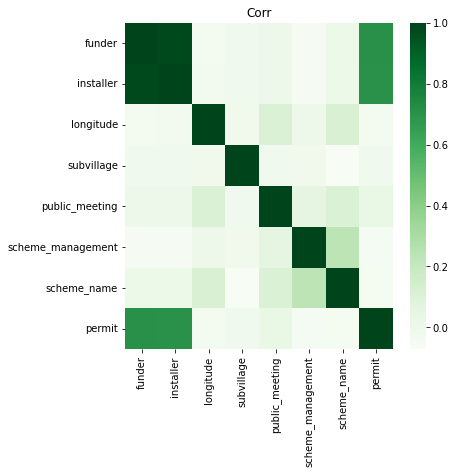

In [230]:
#What kind of correlation is there between untagged data
df_corr = df[cols_with_none.index].isnull()#.corr()
df_matrix = df_corr.corr()
df_matrix

fig = plt.figure(figsize=(6,6))
r = sns.heatmap(df_matrix, cmap="Greens")
r.set_title("Corr")

In [231]:
#Dive into some of the data with Zeros
cols_with_zero = (df==0).sum()
cols_with_zero = cols_with_zero[cols_with_zero>0]
cols_with_zero

id                             1
amount_tsh                 41639
gps_height                 20438
num_private                58643
district_code                 23
population                 21381
public_meeting              5055
permit                     17492
construction_year          20709
functional_flag            27141
public_meeting_clean        5055
permit_clean               17492
construction_year_clean    20709
dtype: int64

Text(0.5, 1.0, 'Corr')

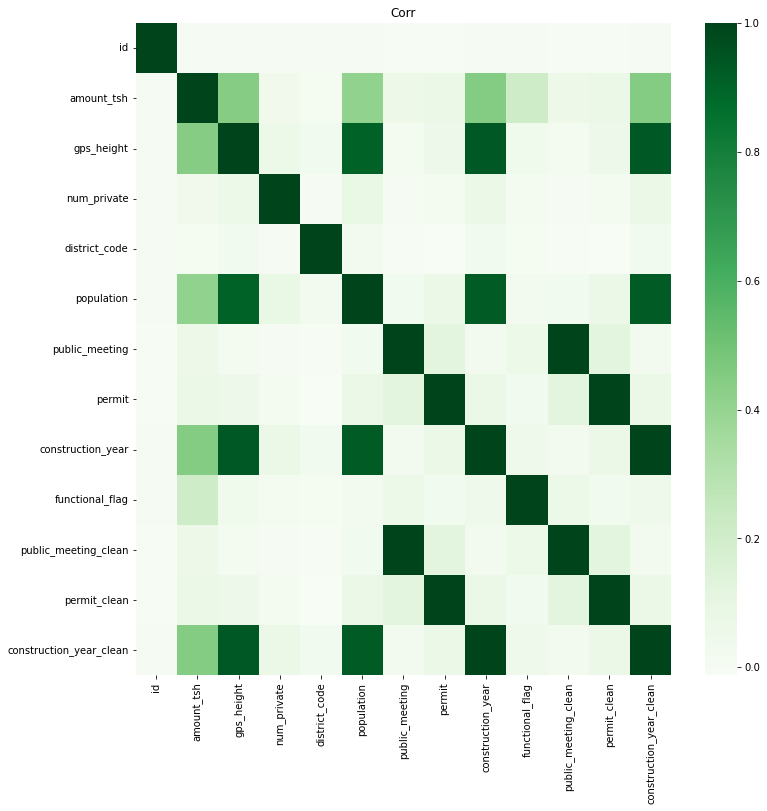

In [232]:
#What kind of correlation is there between zero values
#Key Takeout -> A number of heavy correlations gps_height&construction_year, gps_height&population
df_corr = (df[cols_with_zero.index]==0)#.corr()
df_matrix = df_corr.corr()
df_matrix

fig = plt.figure(figsize=(12,12))
r = sns.heatmap(df_matrix, cmap="Greens")
r.set_title("Corr")

In [233]:
#Looking at the relationship between potential features
fig = ff.create_dendrogram(
    df_matrix, color_threshold=1.5, labels=df_matrix.columns)
fig.update_layout(width=800, height=500)
fig.show()

In [234]:
def stack_plot(
    df, df_src, axis_name,
    size, colors, vertical=True,
    title='',
    orientation='vertical',
    legend_location='top_right'):
    
    data = df.to_dict(orient='list')    
    data[axis_name] = df.index.tolist()

    if vertical:
        p = figure(
            tools=TOOLS, x_range=df.index.tolist(),
            plot_height=size, title=title,
            toolbar_location='above')        
        p.vbar_stack(
            df_src['status_group'].unique().tolist(),
            x=axis_name, width=0.9, color=colors, source=data,
            legend_label=df_src['status_group'].unique().tolist())

        p.y_range.start = 0
    else:
        p = figure(
            tools=TOOLS,
            y_range=df.index.tolist(),
            plot_height=size, title=title,
            toolbar_location='above')        
        p.hbar_stack(df_src['status_group'].unique().tolist(),
                     y=axis_name, height=0.6, color=colors, source=data,
                     legend_label=df_src['status_group'].unique().tolist())
        
        p.x_range.start = 0
        
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = legend_location
    p.legend.orientation = orientation
    show(p)   
      

In [235]:
df_quantity = df[['quantity']].join(pd.get_dummies(df['status_group'])).groupby(
    'quantity')[df['status_group'].unique()].apply(sum)

stack_plot(
    df=df_quantity,
    df_src=df,
    axis_name='quantity',
    size=350,
    colors=COLORS,
    vertical=True,
    title='',
    orientation='vertical',
    legend_location='top_right')

In [236]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,functional_flag,funder_clean,installer_clean,subvillage_clean,public_meeting_clean,scheme_management_clean,scheme_name_clean,permit_clean,construction_year_clean,gps_height_clean,construction_decade,top_funder
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,1,Roman,Roman,Mnyusi B,True,VWC,Roman,False,1999,1300<x<1500,90s,other
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,Other,NaN,True,2010,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1,Grumeti,GRUMETI,Nyamara,none,Other,none,True,2010,1300<x<1500,10s to 2022,other
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,1,Lottery Club,World vision,Majengo,True,VWC,Nyumba ya mungu pipe scheme,True,2009,300<x<700,00s,other
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,NaN,True,1986,submersible,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,0,Unicef,UNICEF,Mahakamani,True,VWC,none,True,1986,0<x<300,80s,Unicef
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,NaN,NaN,True,0,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1,Action In A,Artisan,Kyanyamisa,True,none,none,True,0,zero,no record,other


In [237]:
df_quality = df[['water_quality']].join(pd.get_dummies(df['status_group'])).groupby(
    'water_quality')[df['status_group'].unique()].apply(sum)
stack_plot(
    df=df_quality,
    df_src=df,
    axis_name='water_quality',
    size=350,
    colors=COLORS,
    vertical=True,
    title='',
    orientation='vertical',
    legend_location='top_left')

In [238]:
df_waterpoint = df[['waterpoint_type']].join(pd.get_dummies(df['status_group'])).groupby(
    'waterpoint_type')[df['status_group'].unique()].apply(sum)
stack_plot(
    df=df_waterpoint,
    df_src=df,
    axis_name='waterpoint_type',
    size=350,
    colors=COLORS,
    vertical=True,
    title='',
    orientation='vertical',
    legend_location='top_right')

In [239]:
top_funder = df['funder'].value_counts().head(19).index.tolist()
df['top_funder'] = df['funder'].apply(lambda x: x if x in top_funder else 'other')
df_funder = df[df['top_funder'].isin(top_funder)][['top_funder']].join(
    pd.get_dummies(df[df['top_funder'].isin(top_funder)]['status_group'])).groupby(
    'top_funder')[df['status_group'].unique()].apply(sum)
df_funder.drop("0", axis=0, inplace=True)
stack_plot(
    df=df_funder,
    df_src=df,
    axis_name='funder',
    size=500,
    colors=COLORS,
    vertical=False,
    title='',
    orientation='vertical',
    legend_location='top_right')

In [240]:
df_basin = df[['basin']].join(
    pd.get_dummies(df['status_group'])).groupby(
    'basin')[df['status_group'].unique()].apply(sum)
stack_plot(
    df=df_basin,
    df_src=df,
    axis_name='basin',
    size=400,
    colors=COLORS,
    vertical=False,
    title='',
    orientation='vertical',
    legend_location='top_right')

In [241]:
df_pay = df[['payment']].join(
    pd.get_dummies(df['status_group'])).groupby(
    ['payment'])[df['status_group'].unique()].apply(sum)
stack_plot(
    df=df_pay,
    df_src=df,
    axis_name='payment',
    size=300,
    colors=COLORS,
    vertical=False,
    title='',
    orientation='vertical',
    legend_location='top_right')
